# Vanila GAN(Generative Adversarial Network)

# Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU

# 1. Load MNIST Dataset

- 'generator'의 'tanh' Activation 출력에 적합하도록 정규화

In [3]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalization
X_train = X_train.astype(np.float32) / 127.5 - 1

# Reshape
X_train = X_train.reshape(60000, 784)

11493376/11490434 [==============================] - 0s 0us/step


# 2. 'adam' Optimizer 

- beta_1 : 감쇠율 조정

In [4]:
from keras.optimizers import Adam

adam = Adam(lr = 0.0002, beta_1 = 0.5)

# 3. 'generator' Model

- 랜덤 벡터(잠재공간의 랜덤 포인트)를 입력 받아 이미지 생성
   - noise_dim : 입력 랜덤 벡터 크기
- 'discriminator'를 속이도록 학습
   - 'Real Image'와 같은 'Fake Image' 생성이 목적적

In [5]:
noise_dim = 10

generator = Sequential(name = 'generator')  # 생성자 모델

generator.add(Dense(256, input_shape = (noise_dim,)))  # 10개의 noise data 들어감
generator.add(LeakyReLU())
generator.add(Dense(512)) 
generator.add(LeakyReLU())
generator.add(Dense(1024))
generator.add(LeakyReLU())
generator.add(Dense(784, activation = 'tanh'))         # 레이어를 쌓아서 최종적으로 784개의 fake data 마만든다. 

- Model summary

In [6]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               80

# 4. 'discriminator' Model

- 이미지를 입력 받아 'Real Image'인지 'generator'가 생성한 'Fake Image'인지 판별
   - 이진 분류

In [9]:
from tensorflow.keras.initializers import RandomNormal

discriminator = Sequential(name = 'discriminator')  # 생성자 모델

discriminator.add(Dense(1024,
                        input_shape = (784,),   # generator에서 만들 fake data 크기 
                        kernel_initializer = RandomNormal(stddev = 0.02)))  # kernel_initializer : 파라미터 초기화, 학습속도 빨라진다.
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(512)) 
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1, activation = 'sigmoid'))  # 최종적으로 generator의 데이터가 진짜(1) or 가짜(0) 이진분류

- Model summary

In [10]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)             

> ## 1) 'discriminator' Compile

- 판별자 학습 설정

In [11]:
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = adam) 

# 5. 'gan' Model


> ## 1) 'generator', 'discriminator' 연결

- 'gan' 모델에서 'generator'만 학습하도록 설정
   - discriminator.trainable = False 

In [12]:
discriminator.trainable = False 

gan_input = Input(shape = (noise_dim,))  # generator의 input data(10개)를 초기에 넣고
x = generator(gan_input)                 # generator model로 10개를 학습
output = discriminator(x)                # 결과는 x를 generator로 학습시키고 discriminator로 학습시킨 결과를 말한다.

> ## 2) 'gan' Model

In [13]:
gan = Model(gan_input, output, name = 'gan') # 10개의 input data와 discriminator를 거친 output을 가진 모델 gan

> ## 3) 'gan' summary

In [14]:
gan.summary()

Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
generator (Sequential)       (None, 784)               1463312   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


> ## 4) 'gan' Compile

- 학습 설정

In [15]:
gan.compile(loss = 'binary_crossentropy',
            optimizer = adam)

# 6. Difine 'get_batches( )' Function

- MNIST image batch 생성 : Real, Fake의 128차원을 더해서 이미지 생성 함수

In [16]:
def get_batches(data, batch_size):
    batches = []

    for i in range(data.shape[0] // batch_size):
        batch = data[i * batch_size : (i + 1) * batch_size]  
        batches.append(batch)
    return np.asarray(batches)
# data가 X_train이고 batch_size가 3이면, X_train에서 3개 만큼 뽑아서 batch라고 하고,
# 1개의 batch가 쌓이고 쌓이면 batches가 되고, batches를 array만들어서 출력

# 7. 'visualize_training( )' Function

In [27]:
def visualize_training(epoch, d_losses, g_losses):
    
    # 오차 시각화
    # plt.figure(figsize = (8, 4))
    # plt.plot(d_losses, label = 'Discriminator Loss')
    # plt.plot(g_losses, label = 'Generator Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.show()
    # print('epoch : {}, Discriminator Loss : {}, Generator Loss : {}'.format(epoch, np.asarray(d_losses, g_losses)))

    # 이미지 생성 결과 시각화
    print('epoch : ', epoch)
    noise = np.random.normal(0, 1, size = (24, noise_dim))  # 0 ~ 1의 정규 랜덤 수들이 24행 10열
    generated_images = generator.predict(noise)             # noise의 data로 생성자를 거쳐서 784개의 fake 나온다.
    generated_images = generated_images.reshape(-1, 28, 28) # 784개를 1차원에서 2차원으로 바꾼다

    plt.figure(figsize = (8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i + 1)
        plt.imshow(generated_images[i], interpolation = 'nearest', cmap = 'Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 8. Model Training

- 약 35분
- .fit( ) 
   - 'epoch', 'batch_size' 지정
- .train_on_batch( )
   - 전달 받을 모든 데이터를 사용하여 학습 진행
- 'generator'가 매번 새로운 'Fake Image'를 생성하여 '.train_on_batch( )' 사용용

epoch :  1


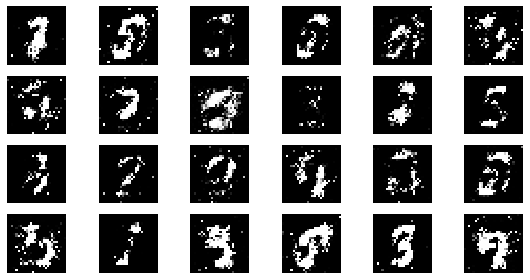

epoch :  5


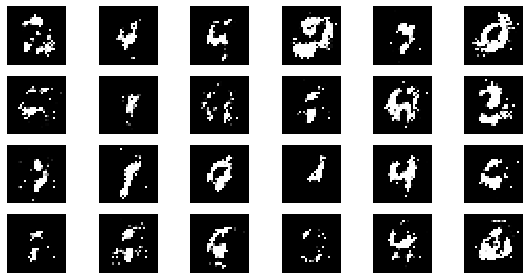

epoch :  10


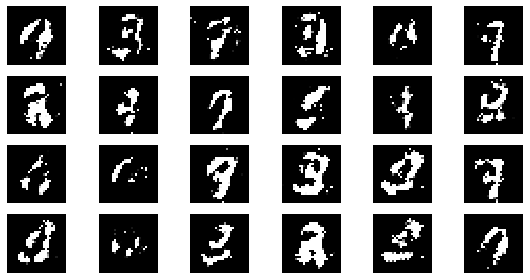

epoch :  15


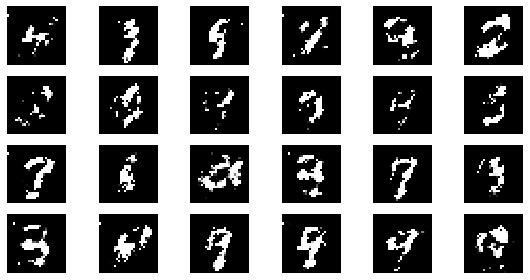

epoch :  20


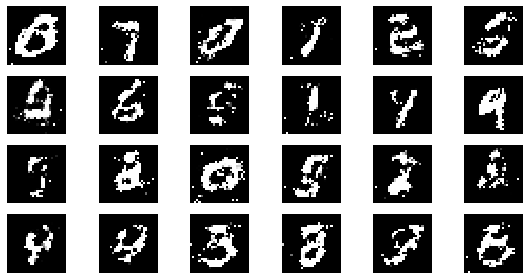

epoch :  25


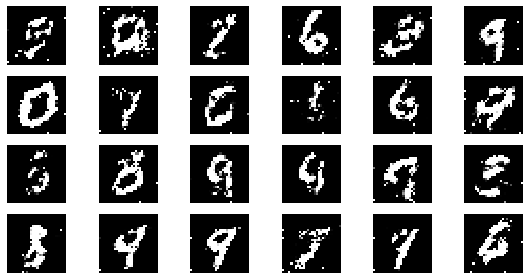

epoch :  30


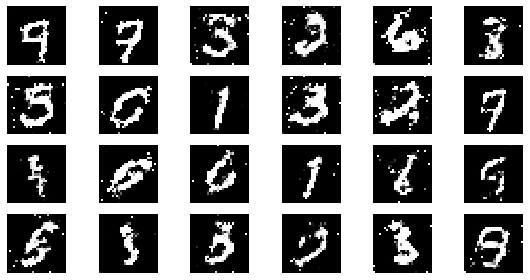

epoch :  35


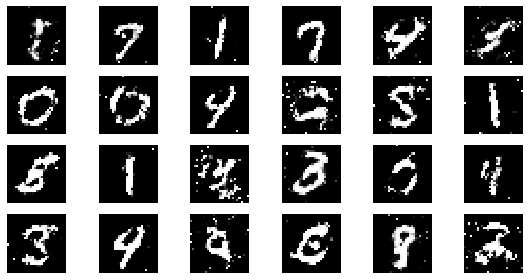

epoch :  40


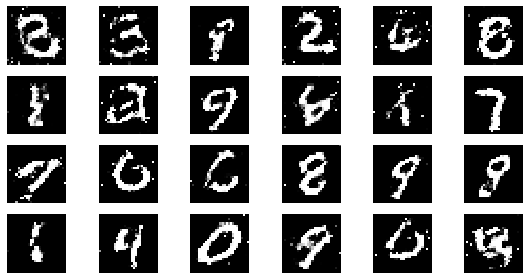

epoch :  45


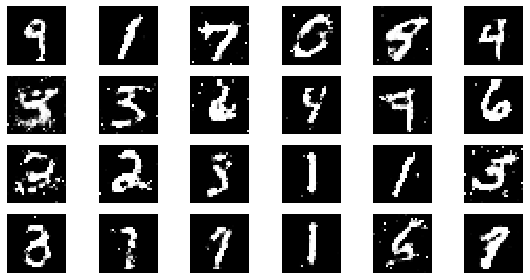

epoch :  50


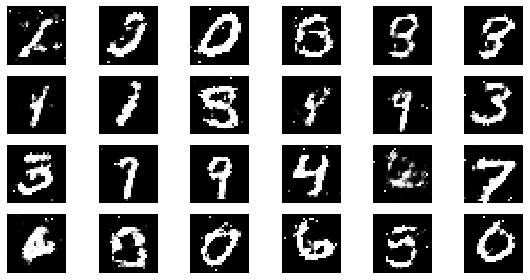

epoch :  55


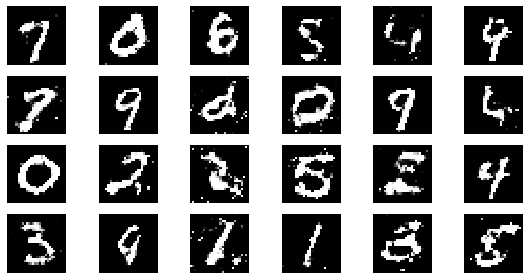

epoch :  60


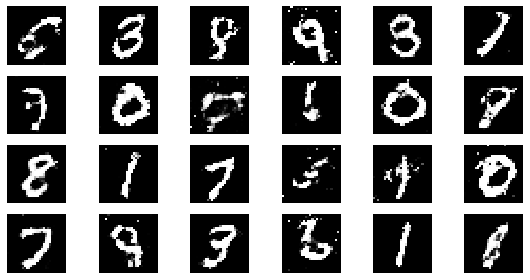

epoch :  65


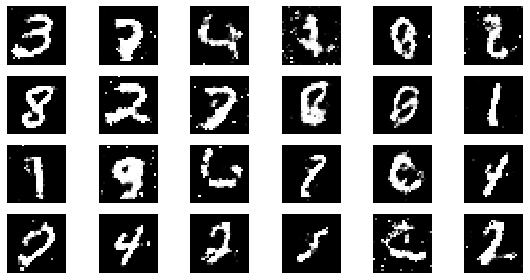

epoch :  70


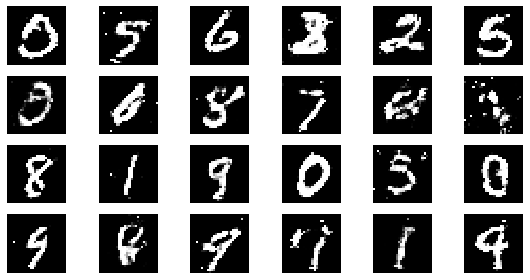

epoch :  75


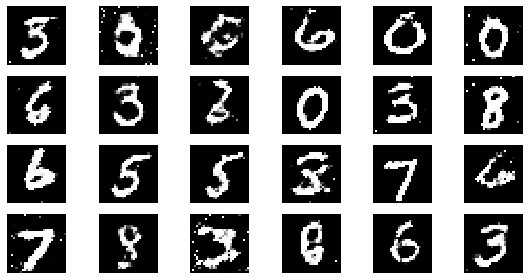

epoch :  80


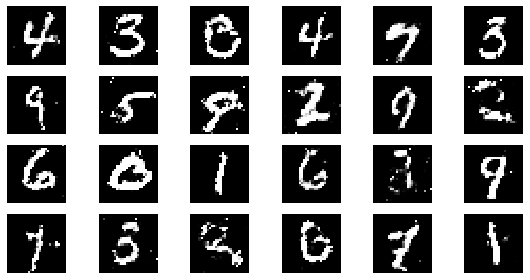

epoch :  85


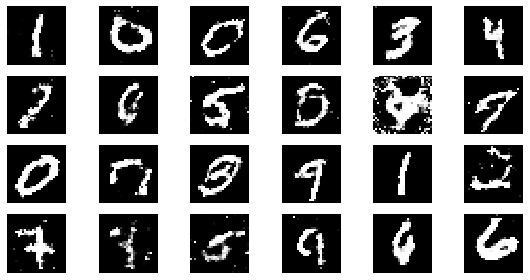

epoch :  90


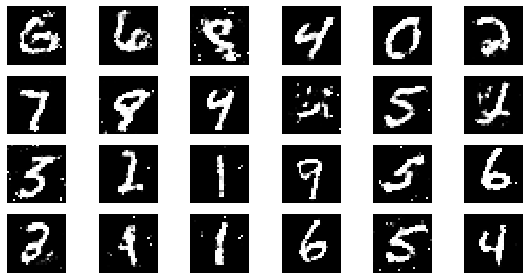

epoch :  95


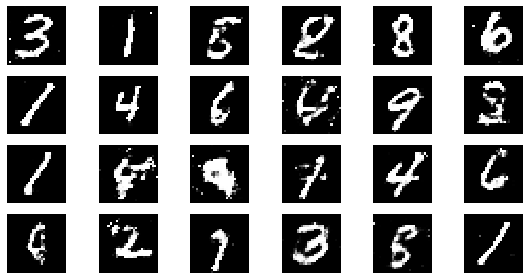

epoch :  100


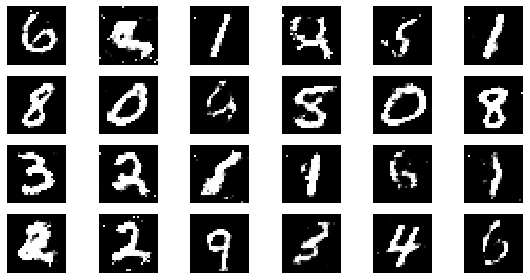

CPU times: user 35min 5s, sys: 1min 49s, total: 36min 54s
Wall time: 35min 16s


In [28]:
%%time

epochs = 100      # 총 100번 돌린다
batch_size = 128  # real, fake에서 128개씩 가져와서

# 'discriminator', 'gan' Loss 저장 List
d_losses = []
g_losses = []

for epoch in range(1, epochs + 1):
  # batch 별 학습
  for real_images in get_batches(X_train, batch_size):   # X_train을 128개만큼 뽑아 이게 real data임  
    # Random Noise 생성
    input_noise = np.random.uniform(-1, 1, size = [batch_size, noise_dim]) # 뽑아온 batch_size에서 랜덤하게 뽑기 위해 random.uniform

    # Fake Image 데이터 생성
    generated_images = generator.predict(input_noise)    # input_noise를 생성자를 통해 학습 시킨 fake data

    # 'gan' 학습용 X 데이터 정의
    x_dis = np.concatenate([real_images, generated_images]) # real(128개)아래에 fake(128개)를 붙여 행렬을 만들어

    # 'gan' 학습용 y 데이터 정의 : 레이블 지정
    y_dis = np.zeros(2 * batch_size)   # batch_size의 왜 두배? real, fake 128개씩 가져오니까 128개의 두배, x_dis의 행 길이만큼의 길이   
    y_dis[: batch_size] = 1            # 앞의 128개 데이터에는 1(real)을 부여, 나머지 128개에 0(fake)을 부여

    # 'discriminator' 학습
    discriminator.trainable = True     # real, fake를 판별 할 일만 남았으니 판별자를 학습 가능하게 freeze 풀어주고,
    d_loss = discriminator.train_on_batch(x_dis, y_dis) # 판별을 진행해서 생성자한테 속은 학습(fake를 real이라고 판단)은 d_loss라고 한다.

    # 'gan' 학습
    noise = np.random.uniform(-1, 1, size = [batch_size, noise_dim])
    y_gan = np.ones(batch_size)        # batch_size만큼 1로 채움 ???

    # 'discriminator' 학습 정지
    discriminator.trainable = False   # 판별자를 학습한 후에는 다시 판별자 freeze 
    g_loss = gan.train_on_batch(noise, y_gan) # 판별자가 맞게 판별한 데이터를 판별자가 틀리게 하기 위해 다시 생성자가 학습

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  # 생성 결과 시각화
  if epoch == 1 or epoch % 5 == 0:
    visualize_training(epoch, d_losses, g_losses)  # 처음엔 숫자 형태가 아니었지만 점점 숫자를 띄는 것을 볼 수 있다

###
# The End
###